# COM3025 Coursework

> Dylan Parker, Harry Payne, Zeya Rabani, James Wright







---


## Import Dataset


---



In [2]:
import numpy as np
from PIL import Image
import h5py
import os
from IPython.display import HTML, display

# This is for displaying the progress bar while importing data
def progress(value, max=100):
    return HTML("""
        Importing Files:
        <progress
            value='{value}'
            max='{max}',
            style='width: 50%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Clone dataset if not already done
![[ -d COM3025 ]] || git clone https://github.com/jw01324/COM3025.git
directory = "./COM3025/Brain Tumor Dataset/Files/"
numberOfFiles = len(os.listdir(directory))

# Create dataset arrays
# Look at README for data structure
labels = np.empty((numberOfFiles,), float) 
images = np.empty((numberOfFiles, 512,512), float) 
tumorBorders = np.empty((numberOfFiles, ), dtype=object)
tumorMask = np.empty((numberOfFiles, 512,512), int) 

# Start showing progress bar
out = display(progress(0, numberOfFiles), display_id=True)

for i,filename in enumerate(os.listdir(directory)):
  # Update progress bar
  out.update(progress(i, numberOfFiles))
  
  with h5py.File(directory + filename, 'r') as file:
    labels[i] = file['cjdata']['label'][()][0][0]
    if len(file['cjdata']['image'][()]) == 512:
      images[i] = np.flipud(np.rot90(file['cjdata']['image'][()]))
      tumorMask[i] = np.flipud(np.rot90(file['cjdata']['tumorMask'][()]))
      tumorBorders[i] = file['cjdata']['tumorBorder'][()][0]
    else: # Some images are 256 so repeat each pixel
      images[i] = np.repeat(np.repeat(np.flipud(np.rot90(file['cjdata']['image'][()])), 2, axis=1), 2, axis=0)
      tumorMask[i] = np.repeat(np.repeat(np.flipud(np.rot90(file['cjdata']['tumorMask'][()])), 2, axis=1), 2, axis=0)
      tumorBorders[i] = [x*2 for x in file['cjdata']['tumorBorder'][()][0]]



---


# Resizing Images


---


*Note: this segment should only ever  be run once, otherwise the tumorMask data will be 
downsized multiple times. It takes a similar amount of time to run as the previous segment (~30s).*

In [3]:
from skimage.transform import resize
from skimage.measure import block_reduce
from copy import deepcopy

#defining the new size of each image
newSize = (128, 128)

#creating empty arrays to hold the resized datasets
images_rs = np.empty((numberOfFiles, newSize[0], newSize[1]), float) 
tumorMask_rs = np.zeros((numberOfFiles, newSize[0], newSize[1]), int)
#create a deepcopy of the tumorBorders  
tumorBorders_rs = deepcopy(tumorBorders)

# Start showing progress bar
out = display(progress(0, numberOfFiles), display_id=True)

#resizing the data and storing it in the new array
for i in range(0,numberOfFiles):
  # Update progress bar
  out.update(progress(i, numberOfFiles))

  #resize each image to the defined new size
  images_rs[i] = resize(images[i], newSize)  

  #reduce the mask to the new size through pooling, this finds the mean between 16 datapoints to be reduced into one
  tumorMask_rs[i] = block_reduce(tumorMask[i], (4,4), np.mean)
  #round the values as the mask only reads 0s and 1s
  tumorMask_rs[i] = np.around(tumorMask_rs[i])

  try: #for arrays formatted as per numpy.array
    tumorBorders_rs[i] = tumorBorders_rs[i]/4
  except TypeError: #for arrays not formatted similarly to numpy arrays, this is the case for some of the arrays within the dataset
    for j in range (len(tumorBorders_rs[i])):
      tumorBorders_rs[i][j] = tumorBorders_rs[i][j]/4



---


# Displaying Resized Images




---




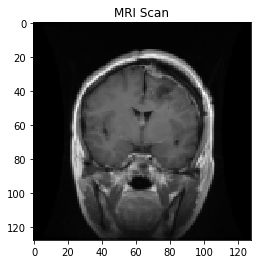

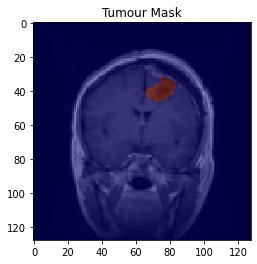

In [4]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("MRI Scan")
plt.imshow(images_rs[0], 'gray', interpolation='none')
plt.show()

plt.figure()
plt.title("Tumour Mask")
plt.imshow(images_rs[0], 'gray', interpolation='none')
plt.imshow(tumorMask_rs[0], 'jet', interpolation='none', alpha=0.5)
plt.show()



---


# Reshaping the images


---
*Note: This adds an extra dimension to the image*



In [5]:
images_rs /= 255 # Get all values 0 < ? < 1      
images_rs = np.expand_dims(images_rs, axis=3) # Adds a dimension to images for Conv2D
tumorMask_rs = np.expand_dims(tumorMask_rs, axis=3) # Adds a dimension to images for Conv2D
print("Shape of train images", images_rs.shape, "containing", images_rs.dtype)
print("Shape of train labels", tumorMask_rs.shape, "containing", tumorMask_rs.dtype)

Shape of train images (3064, 128, 128, 1) containing float64
Shape of train labels (3064, 128, 128, 1) containing int64




---


# Prepare for training


---



In [0]:
#I have adapted this section so that the model is split up 3 times (training, testing, and validation)
#where the validation set is an unseen set of data so that the model can be checked for overfitting.
#This section selects 1715 images for training, 736 for testing, and 613 for validation

#choosing the amount of validation data to hold back
validationSplit = (len(images)*8)//10

#choosing the split for the training and testing dataset (using the validation split point as the max)
splitIndex = (validationSplit*7)//10

x_train = images_rs[:splitIndex]
x_test = images_rs[splitIndex:validationSplit]
x_validate = images_rs[validationSplit:]

y_train = tumorMask_rs[:splitIndex]
y_test = tumorMask_rs[splitIndex:validationSplit]
y_validate = tumorMask_rs[validationSplit:]



---


# Training the model


---


In [33]:
from IPython.display import Image
import matplotlib.pyplot as plt
import keras
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, InputLayer, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose

batch_size = 32
epochs = 10
dropout = 0.2
filters = 32

model = Sequential()
######################## input
model.add(Conv2D(filters,(3,3),padding='same',activation='relu',input_shape=(128,128,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters,(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(dropout))
######################### hidden
model.add(Conv2D(filters*2,(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters*2,(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(dropout))
######################### hidden
model.add(Conv2DTranspose(filters*2,(3,3),strides=(2,2),padding='same'))
model.add(Dropout(dropout))
model.add(Conv2D(filters*2,(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters*2,(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
######################### hidden
model.add(Conv2DTranspose(filters, (3,3),strides=(2,2),padding='same'))
model.add(Dropout(dropout))
model.add(Conv2D(filters,(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters,(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
######################### output
model.add(Conv2D(1,(1,1),activation='sigmoid'))

#model.add(UpSampling2D(size=(32, 32),interpolation='nearest'))
#model.add(Flatten())

opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

#categorical_crossentropy
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

Image(model_to_dot(model).create(prog='dot', format='png'))
history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization_65 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_66 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 64, 64, 64)       



---


# Displaying Accuracy and Loss


---



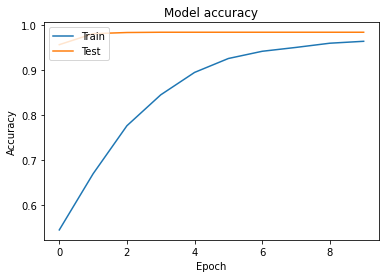

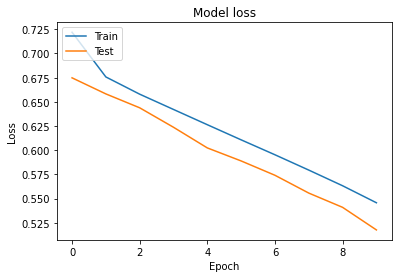

In [8]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



---


# Validating the model


---


In [9]:
#evaluating the loss(error) and accuracy for the validation dataset (unseen data from the dataset)
scores = model.evaluate(x_validate, y_validate, verbose=0)
print("Loss: " + "{:.2f}".format(scores[0] * 100) + "%")
print("Accuracy: " + "{:.2f}".format(scores[1] * 100) + "%")

Loss: 51.75%
Accuracy: 98.49%




---

# Predicting Mask


---



In [0]:
#running two images from the validation segment (not seen by the model) to predict masks
predMask = model.predict(np.expand_dims(x_validate[0], axis=0))
predMask2 = model.predict(np.expand_dims(x_validate[1], axis=0))



---

# Displaying Prediction


---



(613, 128, 128, 1)


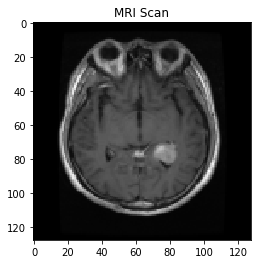

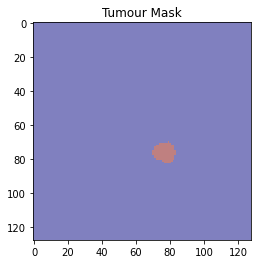

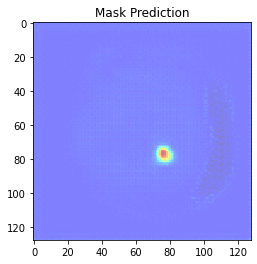

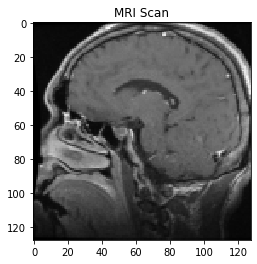

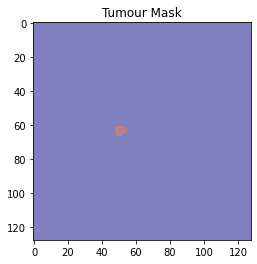

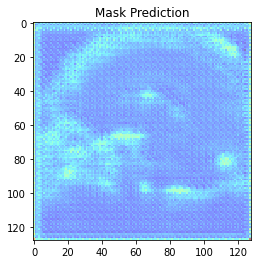

In [35]:
#reducing the dimensions of each array so they can be plotted
image_dis = np.squeeze(x_validate, axis=3)
predMask_dis = np.squeeze(np.squeeze(predMask, axis=3), axis=0)
predMask_dis2 = np.squeeze(np.squeeze(predMask2, axis=3), axis=0)
tumorMask_dis = np.squeeze(tumorMask_rs, axis=3)

plt.figure()
plt.title("MRI Scan")
plt.imshow(image_dis[0], 'gray', interpolation='none')
plt.show()

plt.figure()
plt.title("Tumour Mask")
plt.imshow(tumorMask_dis[validationSplit], 'jet', interpolation='none', alpha=0.5)
plt.show()

plt.figure()
plt.title("Mask Prediction")
plt.imshow(predMask_dis, 'jet', interpolation='none', alpha=0.5)
plt.show()

plt.figure()
plt.title("MRI Scan")
plt.imshow(image_dis[1], 'gray', interpolation='none')
plt.show()

plt.figure()
plt.title("Tumour Mask")
plt.imshow(tumorMask_dis[validationSplit+1], 'jet', interpolation='none', alpha=0.5)
plt.show()

plt.figure()
plt.title("Mask Prediction")
plt.imshow(predMask_dis2, 'jet', interpolation='none', alpha=0.5)
plt.show()